# Walt Whitman Poetry Generator

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [ ]:
path = untar_data(URLs.whitman)
path.ls()

In [4]:
df = pd.read_fwf(path/'whitman.txt', header=None);
df.head()

,0
0,LEAVES OF GRASS
1,By Walt Whitman
2,"Come, said my soul,"
3,"Such verses for my Body let us write, (for we ..."
4,"That should I after return,"


In [6]:
df.columns = ["text"]
df.head()

,text
0,LEAVES OF GRASS
1,By Walt Whitman
2,"Come, said my soul,"
3,"Such verses for my Body let us write, (for we ..."
4,"That should I after return,"


In [7]:
df = df.dropna(subset=["text"]);
df.head()

,text
0,LEAVES OF GRASS
1,By Walt Whitman
2,"Come, said my soul,"
3,"Such verses for my Body let us write, (for we ..."
4,"That should I after return,"


In [8]:
len(df)

17413

In [77]:
data_lm = (TextList.from_df(df, Path(path), col=['text']) 
          .random_split_by_pct(0.1)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch(bs=10))
#data_lm.save('data_lm_whitman');

In [13]:
data_lm.show_batch(rows=10)

idx,text
0,"xxbos i have travel'd a long way merely to look on you to touch you , xxbos looks at the oats and rye , xxbos xxmaj nothing in the xxunk from the xxmaj state xxunk or xxmaj xxunk xxbos xxmaj xxunk me o tongue and lips for xxmaj nature 's sake , souvenirs of xxunk summer , xxbos xxmaj xxunk here and everywhere , eternal float of xxunk ! xxbos"
1,"able , active , receptive , without shame or the need of shame . ) xxbos xxmaj and no man understands any greatness or goodness but his own , or xxbos triumphantly moving , and grander heaving in sight , xxbos should you not speak to me ? xxbos with iron and stone xxunk , ceaseless vehicles , and commerce , xxbos xxmaj the xxunk xxunk , xxunk , sawing"
2,", i xxunk with bare feet , they are xxunk by the xxunk waves , xxbos a word i give to remain in your memories and xxunk , xxbos xxmaj to the free skies unpent and glad and strong . xxbos xxmaj as at thy portals also death , xxbos a call in the midst of the crowd , xxbos xxmaj the voyage balk'd , the course xxunk , lost"
3,"strikes out with xxbos xxmaj no xxunk exists without being from some long previous xxbos xxmaj you shall possess the good of the earth and sun , ( there are millions xxbos xxmaj the xxunk xxunk and xxunk , the large xxunk , xxbos a child said xxmaj what is the grass ? fetching it to me with full hands ; xxbos xxmaj nor rhyme , nor the xxunk ,"
4,", ' mid public , xxunk haunts , in solitude , xxbos xxmaj perfume from battle - fields rising , up from the xxunk arising . xxbos xxmaj in the xxmaj mannahatta , streets , piers , shipping , store - houses , and the xxbos xxmaj your dreams o years , how they penetrate through me ! ( i know not xxbos xxmaj as for an hour carrying us"
5,"in that alone , xxbos end to xxunk it , xxbos xxmaj in xxmaj virginia , the xxunk 's son returning after a long absence , joyfully xxbos xxmaj their postures bringing their weapons downward on the bearers , xxbos xxmaj fresh come , to a new world indeed , yet long prepared , xxbos and not xxunk , that which i xxunk at ; xxbos ( xxmaj there without"
6,"xxmaj the mocking - bird , the xxmaj american mimic , singing all the forenoon , singing xxbos xxup book xxup xxunk . xxup songs xxup of xxup parting xxbos bride , xxbos voices of children and women , xxbos xxmaj pioneers ! o pioneers ! xxbos xxmaj thy xxunk woes and pangs have quell'd them all , xxbos xxmaj those that look xxunk in the faces of xxmaj presidents"
7,"streets , xxbos or lack of money , or xxunk or xxunk , xxbos old , the incessant war ? ) xxbos it is , xxbos xxmaj of life or death , or soldier 's wound , of country 's loss or xxunk , xxbos xxmaj shall beam immortal . xxbos xxmaj by many a xxunk of heat and cold convuls'd , ( by these thyself xxunk , ) xxbos"
8,"and xxmaj state , xxmaj north , xxmaj south , item and aggregate , xxbos xxmaj its sun , and its again , all swing around us . xxbos xxmaj women and men in wisdom innocence and health -- all joy ! xxbos from the ground , xxunk the gray débris , xxbos 11 xxbos i am an xxunk of things accomplish'd , and i an xxunk of things to"
9,"nestling close , always xxunk , xxbos xxmaj and then the song of each xxunk of these xxmaj states . xxbos xxmaj eternal i rise impalpable out of the land and the xxunk sea , xxbos xxmaj or down from the great lakes or in xxmaj pennsylvania , or on deck along xxbos i do not trouble my spirit to xxunk itself or be understood , xxbos xxmaj xxunk xxmaj"


In [57]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


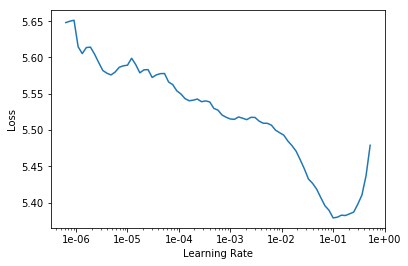

In [18]:
learn.recorder.plot(skip_end=15)

In [59]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.845031,3.750297,0.457575


In [55]:
learn.save('whit_head')

In [56]:
learn.load('whit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [35]:
learn.fit_one_cycle(40, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.872967,3.777957,0.457651
2,0.877892,3.756788,0.460477
3,0.880070,3.766198,0.457502
4,0.880906,3.762648,0.459721
5,0.901820,3.769999,0.458614
6,0.915218,3.751778,0.459732
7,0.918561,3.765309,0.458806
8,0.925346,3.748065,0.457820
9,0.941944,3.781906,0.454736
10,0.957599,3.791858,0.456848


In [36]:
learn.save('whit5')

In [59]:
learn.load('whit5');

In [101]:
# first text
first_string = learn.predict('Come', 2000, temperature=1.1, min_p=0.001) 

dict_of_texts = {'Come': first_string}
for i in range(0,5):
    a = random.randint(1,1999)
    csv_string = learn.predict(first_string[a], 2000, temperature=1.1, min_p=0.001)
    dict_of_texts[a] = csv_string
len(dict_of_texts)

6

In [102]:
final_string = '## Chapter 1 \n'
i = 2
for key, value in dict_of_texts.items():
    final_string += value + ' \n'
    final_string += '## Chapter ' + str(i) + ' \n'
    i += 1
final_string[1990:2200]

" off - man 's first to the xxup iii , xxbos xxmaj states ! but many a little black we know not out of the world of the first - 2 xxbos xxmaj god and i know who has the same under the two together , xxbos xxmaj "

In [103]:
words = final_string.split()
for i, word in enumerate(words):
    if word == 'xxbos':
        words[i] = '\n' #replace with <br/> in web app
    elif word == 'xxmaj':
        try:
            words[i+1] = words[i+1][0].upper() + words[i+1][1:]
            words[i] = ''
        except:
            continue
    elif word == 'xxup':
        try:
            words[i+1] = words[i+1].upper()
            words[i] = ''
        except:
            continue            
    elif word == 'xxunk' or word == '(' or word == ')' or word == '"':
        words[i] = ''   
    elif word == ',':
        words[i] = ''
    elif word == '.' or word == '?' or word == '!' or word == ';':
        words[i-1]+= words[i]
        words[i] = ''
    elif word[0] == "'":
        words[i-1]+= words[i]
        words[i] = ''   
#print(' '.join(words))

In [104]:
import csv
with open('whitman_output.csv','w') as file:
    for line in ' '.join(words):
        file.write(line)

## For Inference

In [9]:
data_lm_whitman = TextLMDataBunch.load(path, 'data_lm_whitman');

In [44]:
# create a blank csv to create an empty data bunch for your web app. Be sure to load in your language model vocabulary.
data_bunch = (TextList.from_csv(path, csv_name='blank.csv', vocab=data_lm_whitman.vocab)
    .random_split_by_pct()
    .label_for_lm()
    .databunch(bs=10))

In [10]:
learn = language_model_learner(data_bunch, pretrained_model=None)

In [11]:
learn.load('whit5');